# Определение возраста покупателей

## Исследовательский анализ данных

In [4]:
! pip install tensorflow

     -------------------------------------- 300.9/300.9 MB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 6.2 MB/s eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 5.5 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 5.0 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 4.7 MB/s eta 0:00:00
     -------------------------------------- 938.6/938.6 kB 4.9 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 5.0 MB/s eta 0:00:00
     -------------------------------------- 413.4/413.4 kB 6.4 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00
     -------------------------------------- 133.7/133.7 kB 3.9 MB/s eta 0:00:00
     -------------------------------------- 442.0/442.0 kB 5.5 MB/s eta 0:00:00
     -------------------------------------- 186.

In [5]:
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from PIL import Image

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
df = pd.read_csv('..//faces//labels.csv')

In [3]:
datagen = ImageDataGenerator(rescale = 1 / 255)

In [4]:
train_gen_flow = datagen.flow_from_dataframe(
    dataframe = df, 
    directory = '/datasets/faces/final_files/',
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = (224, 224),
    batch_size = 32,
    class_mode ='raw',
    seed = 12345)

Found 7591 validated image filenames.


In [5]:
print(f'Размер выборки: {df.shape}')

Размер выборки: (7591, 2)


In [9]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000



**Промежуточный вывод**  
    
В нашем распоряжении 7591 размеченных фотографий, на которых нейросеть должна научиться определять возраст человека. Так как мы решаем задачу регрессии и значения могут вырироваться от 1 до 100, то можно предположить, что 7591 фотографий не так уж и много. Поэтому для "увелечения" данных можно воспользоваться аугментацией, ведь она позволяет измененять размер изображений, добавлять  шум, измененять яркость, контрастность и другие параметры. Это позволяет создать больше вариантов данных, на которых можно тренировать модель. 
    

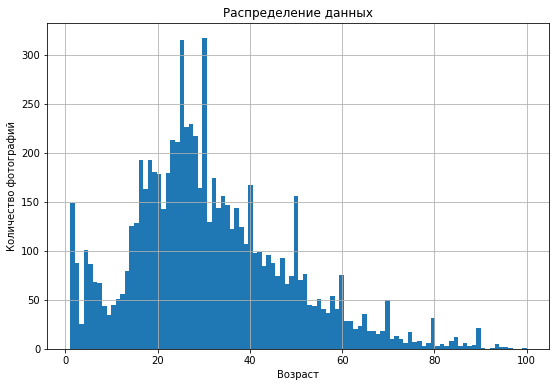

In [6]:
plt.figure(figsize=(9, 6))
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.title('Распределение данных', loc = 'center')
df.real_age.hist(bins = 100);
plt.show()

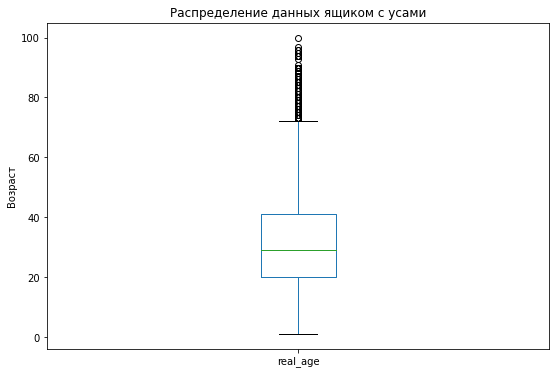

In [20]:
df.plot(kind = 'box', figsize=(9, 6));
plt.ylabel('Возраст')
plt.title('Распределение данных ящиком с усами', loc = 'center');

**Промежуточный вывод**  

По представленной гистограмме можно заметить, что наблюдается дизбаланс классов: присутствует большее количество фотографий людей, которым от 20 до 40, фотографии людей, которым 40+,  с увелечением возростного порога начинают убывать. Наибольшее число данных приходится на диапазон возрастов от 18 до 60 лет. Меньше всего фотографий людей от 61 лет и старше. Немного непонятно для чего в наборе данных используются данные фотографий людей чей возраст варируется от 1 до 6 лет, ведь они никак не попадают под клиентскую базу магазина

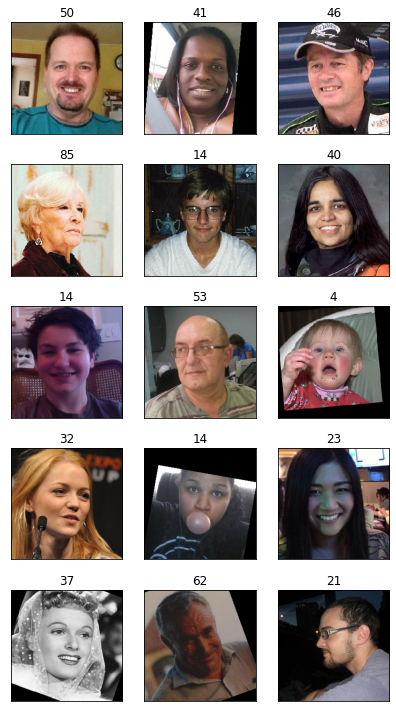

In [7]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize = (6, 10))
for i in range(15):
    fig.add_subplot(5, 3, i + 1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Промежуточный вывод**  

По выделенной части фотографии мы можем заметить, что у данных нет единой концепции, так как все данные устроены по разному: у них разный размер фотографий, положение лиц отличается, большая чать данных имеет разную ориентацию и на некоторых фотографиях присутствуют дефекты (обрезанные лица, плохое качество фотографии), все это может негативно сказать ся на предсказании модели. Чтобы это избежать магазин может поставить камеру прямо перед кассой, чтобы все изображения имели одиноковую структуру и модель выдавала более корректные предсказания

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [ ]:
def load_test(path):  
  df = pd.read_csv(path + '/labels.csv')  
  
  test_datagen = ImageDataGenerator(  
      rescale = 1 / 255)  
  
  test_gen_flow = test_datagen.flow_from_dataframe(  
      df,  
      directory = path + '/final_files',  
      x_col = 'file_name',  
      y_col = 'real_age',  
      target_size = (224, 224),  
      class_mode = 'raw',  
      batch_size = 32,  
      shuffle = True,  
      seed = 12345,  
      subset = 'validation'  
  )  
  
  return test_gen_flow  

In [ ]:
def create_model(input_shape):  
  optimizer = Adam(lr = 0.0001)  
  backbone = ResNet50(  
      input_shape = input_shape,  
      weights ='imagenet',  
      include_top = False  
  )  
  model = Sequential()  
  model.add(backbone)  
  model.add(GlobalAveragePooling2D())  
  model.add(Dense(300, activation = 'relu'))  
  model.add(Dense(1, activation = 'relu'))  
  model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae'])  

  return model  

In [ ]:
def train_model(model, train_data, test_data, batch_size = None, epochs = 20, steps_per_epoch = None, validation_steps = None):
  model.fit(  
      train_data,  
      validation_data = test_data,  
      batch_size = batch_size,  
      epochs = epochs,  
      steps_per_epoch = steps_per_epoch,  
      validation_steps = validation_steps,  
      verbose = 2  
      )  
    
  return model  

```

Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 66s - loss: 193.3851 - mae: 10.1269 - val_loss: 641.6086 - val_mae: 20.3418
Epoch 2/20
178/178 - 56s - loss: 67.3507 - mae: 6.2405 - val_loss: 664.4480 - val_mae: 20.7579
Epoch 3/20
178/178 - 56s - loss: 41.4815 - mae: 4.9025 - val_loss: 432.0458 - val_mae: 15.7367
Epoch 4/20
178/178 - 56s - loss: 32.0825 - mae: 4.2797 - val_loss: 166.5495 - val_mae: 9.4023
Epoch 5/20
178/178 - 54s - loss: 22.6242 - mae: 3.6033 - val_loss: 97.0210 - val_mae: 7.4102
Epoch 6/20
178/178 - 53s - loss: 17.4048 - mae: 3.1346 - val_loss: 87.2309 - val_mae: 7.1364
Epoch 7/20
178/178 - 53s - loss: 14.8703 - mae: 2.8868 - val_loss: 69.2166 - val_mae: 6.2726
Epoch 8/20
178/178 - 53s - loss: 11.7238 - mae: 2.5559 - val_loss: 65.6470 - val_mae: 5.9781
Epoch 9/20
178/178 - 53s - loss: 10.4962 - mae: 2.4129 - val_loss: 69.8672 - val_mae: 6.3761
Epoch 10/20
178/178 - 54s - loss: 10.0237 - mae: 2.3251 - val_loss: 64.6864 - val_mae: 5.9379
Epoch 11/20
178/178 - 57s - loss: 8.0482 - mae: 2.1189 - val_loss: 62.9292 - val_mae: 5.9275
Epoch 12/20
178/178 - 57s - loss: 7.7000 - mae: 2.0769 - val_loss: 60.0705 - val_mae: 5.8040
Epoch 13/20
178/178 - 57s - loss: 7.7394 - mae: 2.0644 - val_loss: 64.5885 - val_mae: 6.1089
Epoch 14/20
178/178 - 57s - loss: 7.0183 - mae: 1.9939 - val_loss: 64.6732 - val_mae: 5.9718
Epoch 15/20
178/178 - 57s - loss: 7.2830 - mae: 2.0249 - val_loss: 63.7524 - val_mae: 5.9818
Epoch 16/20
178/178 - 57s - loss: 7.1763 - mae: 2.0274 - val_loss: 66.9943 - val_mae: 5.9352
Epoch 17/20
178/178 - 57s - loss: 7.2975 - mae: 2.0257 - val_loss: 64.2864 - val_mae: 5.8837
Epoch 18/20
178/178 - 57s - loss: 6.9210 - mae: 1.9948 - val_loss: 60.0298 - val_mae: 5.7543
Epoch 19/20
178/178 - 57s - loss: 6.8017 - mae: 1.9619 - val_loss: 62.2739 - val_mae: 5.9716
Epoch 20/20
178/178 - 40s - loss: 7.1871 - mae: 2.0277 - val_loss: 64.9213 - val_mae: 6.1188
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 65.6787 - mae: 6.1878
Test MAE: 6.1878
```

## Анализ обученной модели

Выводы: 
  1) Была разработана модель для супермаркета, которая по фотографии покупателя может определит его примерный возраст.  
  
  2) Для реализации данного проекта мы провели исследовательский анализ набора фотографий и подготовили данные к обучению. По возрастам имеется сильный дисбаланс.   
  
  3) Для улучшения качества модели, можно расширить датасет, устранив дисбаланс между возрастными категориями.  

  4) В качестве основы для нашей модели мы взяли архитектуру свёрточной нейронной сети ResNet предобученной на наборе ImageNet. Это позволило нам сократить время на обучение нашей модели и как следствие уменьшить расходы на вычислительные ресуры.  

  5) Обученную модель мы проверили на тестовой выборке. Метрика MAE составила  6.1878  
  
  6) Минимальный порог метрики установленный заказчиком равен 8, поэтому можно сделать вывод, что задача выполнена успешно.